# 14-6. 프로젝트: 한국어 QA 모델 만들기
아래의 데이터셋은 bAbI 데이터셋을 저자가 한국어로 변환한 한국어 버전의 bAbI 데이터셋입니다.



## [데이터셋 소개]
데이터셋의 형태는 아래와 같이 영어 데이터셋과 동일합니다.

```
1 은경이는 복도로 가버렸습니다.
2 필웅이는 화장실로 뛰어갔습니다.
3 은경이는 어디야?     복도  1
4 수종이는 화장실로 복귀했습니다.
5 은경이는 침실로 갔습니다.
6 필웅이는 어디야?     화장실 2
7 은경이는 복도로 이동했습니다.
8 경임이는 부엌으로 뛰어갔습니다.
9 경임이는 어디야?     부엌  8
10 경임이는 복도로 가버렸습니다.
11 은경이는 정원으로 이동했습니다.
12 경임이는 어디야?     복도  10
13 경임이는 화장실로 복귀했습니다.
14 경임이는 부엌으로 갔습니다.
15 경임이는 어디야?     부엌  14
```

Step 1. 토크나이저 변경하기 (매우 중요!!!)
영어권 언어는 띄어쓰기만해도 단어들이 잘 분리되지만, 한국어는 그렇지 않다고 앞에서 몇 차례 언급했었죠? 한국어 데이터를 사용하여 모델을 구현하는 것만큼 이번에는 형태소 분석기를 사용해서 단어 토큰화를 해보겠습니다.

그런데 형태소 분석기를 사용할 때, 이런 상황에 봉착한다면 어떻게 해야할까요?
```
형태소 분석 입력 : '은경이는 사무실로 갔습니다.'
형태소 분석 결과 : ['은', '경이', '는', '사무실', '로', '갔습니다', '.']
```
사실 위 문장에서 '은경이'는 사람 이름이므로 제대로 된 결과를 얻기 위해서는 '은', '경이'와 같이 글자가 분리되는 것이 아니라 '은경이' 또는 최소한 '은경'이라는 단어 토큰을 얻어야만 합니다.

이런 경우에는 형태소 분석기에 사용자 사전을 추가해줄 수 있습니다.

'은경이'는 하나의 단어이기 때문에 분리하지말라고 형태소 분석기에 알려주는 것이죠.

사용자 사전을 추가하는 방법은 형태소 분석기마다 다소 다른데, 생각보다 복잡한 경우도 많습니다. 이번 실습에서는 Customized Konlpy라는 사용자 사전 추가가 매우 쉬운 패키지를 사용합니다.




가령, 트위터라는 형태소 분석기를 사용한다고 하였을 때, '은경이'라는 단어를 사용자 사전에 추가하고 나서 문장을 형태소 분석하려면 어떻게 해야 할까요?

```
# 예시 코드
from ckonlpy.tag import Twitter
twitter = Twitter()
twitter.add_dictionary('은경이', 'Noun')
twitter.morphs('은경이는 사무실로 갔습니다.')
```

In [1]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re

In [6]:
# 환경에 맞게 경로 수정
home_dir = os.getenv('HOME')+'/aiffel/babi_memory_net'

# 환경에 맞게 경로 적절히 수정
# DATA_DIR = home_dir + '/babi_memory_net'
TRAIN_FILE = os.path.join(home_dir, "qa1_single-supporting-fact_train_kor.txt")
TEST_FILE = os.path.join(home_dir, "qa1_single-supporting-fact_test_kor.txt")

In [7]:
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    # lno, text = line.split(" ", 1) # ID와 TEXT 분리
    i = i + 1
    print(line)
    if i == 20:
        break

1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 필웅이는 어디야? 	화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 수종이는 어디야? 	복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 수종이는 어디야? 	복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 수종이는 어디야? 	사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 경임이는 어디야? 	화장실	8
1 경임이는 사무실로 가버렸습니다.
2 경임이는 화장실로 이동했습니다.
3 경임이는 어디야? 	화장실	2
4 필웅이는 침실로 이동했습니다.
5 수종이는 복도로 갔습니다.


In [8]:
## 데이터 전처리

def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []
        
        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [9]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [10]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [11]:
print("train 스토리 개수:", len(train_stories))
print("train 질문 개수:", len(train_questions))
print("train 답변 개수:", len(train_answers))
print("test 스토리 개수:", len(test_stories))
print("test 질문 개수:", len(test_questions))
print("test 답변 개수:", len(test_answers))

train 스토리 개수: 10000
train 질문 개수: 10000
train 답변 개수: 10000
test 스토리 개수: 1000
test 질문 개수: 1000
test 답변 개수: 1000


In [12]:
train_stories[3878]

['수종이는 화장실로 뛰어갔습니다.',
 '경임이는 사무실로 갔습니다.',
 '은경이는 부엌으로 이동했습니다.',
 '경임이는 화장실로 갔습니다.',
 '수종이는 복도로 갔습니다.',
 '필웅이는 부엌으로 가버렸습니다.',
 '수종이는 부엌으로 이동했습니다.',
 '수종이는 화장실로 가버렸습니다.']

In [13]:
train_questions[:5]

['필웅이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '경임이는 어디야? ']

In [14]:
train_answers[:5]

['화장실', '복도', '복도', '사무실', '화장실']

In [15]:
# 예시 코드
from ckonlpy.tag import Twitter

twitter = Twitter()
twitter.add_dictionary('수종이', 'Noun')
twitter.add_dictionary('경임이', 'Noun')
twitter.add_dictionary('은경이', 'Noun')
twitter.add_dictionary('필웅이', 'Noun')

twitter.morphs('은경이는 사무실로 갔습니다.')

/home/aiffel-dj47/anaconda3/envs/aiffel/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


['은경이', '는', '사무실', '로', '갔습니다', '.']

In [ ]:
# def tokenize(sent):
#     return [ x.strip() for x in re.sub(r"\s+|\b", '\f', sent).split('\f') if x.strip() ] # python 3.7의 경우 
#     # return [ x.strip() for x in re.split('(\W+)?', sent) if x.strip()] # python 3.6의 경우

In [26]:
def tokenize(sent):
    return twitter.morphs(sent)

In [28]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [29]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [30]:
print(word2idx)

{'는': 1, '.': 2, '로': 3, '했습니다': 4, '으로': 5, '경임이': 6, '은경이': 7, '수종이': 8, '필웅이': 9, '이동': 10, '가버렸습니다': 11, '뛰어갔습니다': 12, '복귀': 13, '화장실': 14, '정원': 15, '복도': 16, '갔습니다': 17, '사무실': 18, '부엌': 19, '침실': 20, '어디': 21, '야': 22, '?': 23}


In [31]:
vocab_size = len(word2idx) + 1

In [32]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 70
질문의 최대 길이 : 5


In [33]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [34]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [35]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 70) (10000, 5) (10000, 24) (1000, 70) (1000, 5) (1000, 24)


In [36]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
import matplotlib.pyplot as plt

In [37]:
# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

In [38]:
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

Stories : Tensor("input_1:0", shape=(None, 70), dtype=float32)
Question: Tensor("input_2:0", shape=(None, 5), dtype=float32)


In [39]:
# 스토리를 위한 첫 번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원
 
# 스토리를 위한 두 번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [40]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [41]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m, '\n')
print('Input encoded c', input_encoded_c, '\n')
print('Question encoded', question_encoded, '\n')

Input encoded m Tensor("sequential/Identity:0", shape=(None, 70, 50), dtype=float32) 

Input encoded c Tensor("sequential_1/Identity:0", shape=(None, 70, 5), dtype=float32) 

Question encoded Tensor("sequential_2/Identity:0", shape=(None, 5, 50), dtype=float32) 



In [42]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape Tensor("activation/Identity:0", shape=(None, 70, 5), dtype=float32)


In [43]:
# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

Response shape Tensor("permute/Identity:0", shape=(None, 5, 70), dtype=float32)


In [44]:
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Answer shape Tensor("concatenate/Identity:0", shape=(None, 5, 120), dtype=float32)


In [45]:
import os

# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
 
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))
 
# 훈련 후에는 모델 저장
model_path = os.getenv('HOME')+'/aiffel/babi_memory_net/model.h5'
model.save(model_path)

Epoch 1/120
313/313 [==============================] - 1s 4ms/step - loss: 1.8873 - acc: 0.1654 - val_loss: 1.7957 - val_acc: 0.1490
Epoch 2/120
313/313 [==============================] - 1s 3ms/step - loss: 1.7215 - acc: 0.2466 - val_loss: 1.5912 - val_acc: 0.3430
Epoch 3/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5938 - acc: 0.3515 - val_loss: 1.5027 - val_acc: 0.3940
Epoch 4/120
313/313 [==============================] - 1s 4ms/step - loss: 1.4875 - acc: 0.4181 - val_loss: 1.4444 - val_acc: 0.4490
Epoch 5/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4464 - acc: 0.4433 - val_loss: 1.4384 - val_acc: 0.4590
Epoch 6/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4235 - acc: 0.4589 - val_loss: 1.4022 - val_acc: 0.4740
Epoch 7/120
313/313 [==============================] - 1s 3ms/step - loss: 1.3893 - acc: 0.4748 - val_loss: 1.3557 - val_acc: 0.5060
Epoch 8/120
313/313 [==============================] - 1s 3ms/step - 

313/313 [==============================] - 1s 3ms/step - loss: 0.1542 - acc: 0.9447 - val_loss: 0.3660 - val_acc: 0.8840
Epoch 63/120
313/313 [==============================] - 1s 3ms/step - loss: 0.1455 - acc: 0.9489 - val_loss: 0.3878 - val_acc: 0.8830
Epoch 64/120
313/313 [==============================] - 1s 3ms/step - loss: 0.1424 - acc: 0.9533 - val_loss: 0.3889 - val_acc: 0.8850
Epoch 65/120
313/313 [==============================] - 1s 3ms/step - loss: 0.1492 - acc: 0.9509 - val_loss: 0.3823 - val_acc: 0.8880
Epoch 66/120
313/313 [==============================] - 1s 4ms/step - loss: 0.1263 - acc: 0.9557 - val_loss: 0.3587 - val_acc: 0.8890
Epoch 67/120
313/313 [==============================] - 1s 3ms/step - loss: 0.1230 - acc: 0.9580 - val_loss: 0.4078 - val_acc: 0.8830
Epoch 68/120
313/313 [==============================] - 1s 3ms/step - loss: 0.1146 - acc: 0.9592 - val_loss: 0.3487 - val_acc: 0.8940
Epoch 69/120
313/313 [==============================] - 1s 3ms/step - loss:

In [46]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 2ms/step - loss: 0.3823 - acc: 0.9320

 테스트 정확도: 0.9320


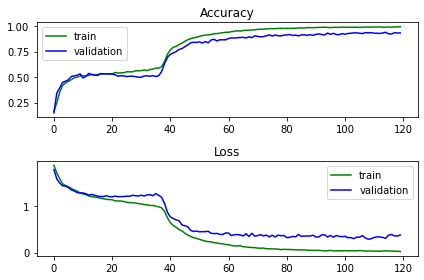

In [47]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [48]:
NUM_DISPLAY = 30

print("{:20}|{:7}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:8} {}".format(question, label, prediction))

질문                  |실제값    |예측값
---------------------------------------
은경이 는 어디 야 ?        : 복도       복도
필웅이 는 어디 야 ?        : 화장실      화장실
경임이 는 어디 야 ?        : 부엌       부엌
경임이 는 어디 야 ?        : 복도       복도
경임이 는 어디 야 ?        : 부엌       부엌
경임이 는 어디 야 ?        : 복도       복도
경임이 는 어디 야 ?        : 정원       정원
수종이 는 어디 야 ?        : 복도       복도
경임이 는 어디 야 ?        : 사무실      정원
수종이 는 어디 야 ?        : 사무실      화장실
필웅이 는 어디 야 ?        : 부엌       부엌
필웅이 는 어디 야 ?        : 정원       정원
수종이 는 어디 야 ?        : 사무실      사무실
필웅이 는 어디 야 ?        : 침실       침실
필웅이 는 어디 야 ?        : 침실       정원
은경이 는 어디 야 ?        : 부엌       부엌
은경이 는 어디 야 ?        : 정원       정원
은경이 는 어디 야 ?        : 부엌       부엌
수종이 는 어디 야 ?        : 사무실      사무실
은경이 는 어디 야 ?        : 부엌       복도
필웅이 는 어디 야 ?        : 복도       복도
은경이 는 어디 야 ?        : 사무실      사무실
은경이 는 어디 야 ?        : 사무실      사무실
경임이 는 어디 야 ?        : 복도       복도
수종이 는 어디 야 ?        : 침실       침실
경임이 는 어디 야 ?        : 침실       침실
필웅이 는 어디 야 ?        : 침실       침실
수종이

## Step 2. 형태소 분석 후 불용어 처리하기
형태소 분석기로 문자를 분석해보면 '는', '으로' 등 분석에 크게 도움이 되지 않을 것 같은 토큰들이 나올 거에요. 처음에는 이 토큰들도 그대로 사용해서 모델을 구현해보고, 두 번째 구현에서는 이 토큰들을 전처리 과정에서 불용어 처리하여 제외해 봅시다.

In [6]:
# 환경에 맞게 경로 수정
home_dir = os.getenv('HOME')+'/aiffel/babi_memory_net'

# 환경에 맞게 경로 적절히 수정
# DATA_DIR = home_dir + '/babi_memory_net'
TRAIN_FILE = os.path.join(home_dir, "qa1_single-supporting-fact_train_kor.txt")
TEST_FILE = os.path.join(home_dir, "qa1_single-supporting-fact_test_kor.txt")

In [7]:
i = 0
lines = open(TRAIN_FILE , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    # lno, text = line.split(" ", 1) # ID와 TEXT 분리
    i = i + 1
    print(line)
    if i == 20:
        break

1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 필웅이는 어디야? 	화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 수종이는 어디야? 	복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 수종이는 어디야? 	복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 수종이는 어디야? 	사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 경임이는 어디야? 	화장실	8
1 경임이는 사무실로 가버렸습니다.
2 경임이는 화장실로 이동했습니다.
3 경임이는 어디야? 	화장실	2
4 필웅이는 침실로 이동했습니다.
5 수종이는 복도로 갔습니다.


In [8]:
## 데이터 전처리

def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []
        
        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [9]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [10]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [11]:
print("train 스토리 개수:", len(train_stories))
print("train 질문 개수:", len(train_questions))
print("train 답변 개수:", len(train_answers))
print("test 스토리 개수:", len(test_stories))
print("test 질문 개수:", len(test_questions))
print("test 답변 개수:", len(test_answers))

train 스토리 개수: 10000
train 질문 개수: 10000
train 답변 개수: 10000
test 스토리 개수: 1000
test 질문 개수: 1000
test 답변 개수: 1000


In [12]:
train_stories[3878]

['수종이는 화장실로 뛰어갔습니다.',
 '경임이는 사무실로 갔습니다.',
 '은경이는 부엌으로 이동했습니다.',
 '경임이는 화장실로 갔습니다.',
 '수종이는 복도로 갔습니다.',
 '필웅이는 부엌으로 가버렸습니다.',
 '수종이는 부엌으로 이동했습니다.',
 '수종이는 화장실로 가버렸습니다.']

In [13]:
train_questions[:5]

['필웅이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '경임이는 어디야? ']

In [14]:
train_answers[:5]

['화장실', '복도', '복도', '사무실', '화장실']

In [15]:
# 예시 코드
from ckonlpy.tag import Twitter

twitter = Twitter()
twitter.add_dictionary('수종이', 'Noun')
twitter.add_dictionary('경임이', 'Noun')
twitter.add_dictionary('은경이', 'Noun')
twitter.add_dictionary('필웅이', 'Noun')

twitter.morphs('은경이는 사무실로 갔습니다.')

/home/aiffel-dj47/anaconda3/envs/aiffel/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


['은경이', '는', '사무실', '로', '갔습니다', '.']

In [ ]:
# def tokenize(sent):
#     return [ x.strip() for x in re.sub(r"\s+|\b", '\f', sent).split('\f') if x.strip() ] # python 3.7의 경우 
#     # return [ x.strip() for x in re.split('(\W+)?', sent) if x.strip()] # python 3.6의 경우

In [51]:
from ckonlpy.tag import Postprocessor

stopwords = {'는', '으로', '로', '야'}

postprocessor = Postprocessor(
    base_tagger = twitter,
    stopwords = stopwords)

In [70]:
print(postprocessor.pos('은경이는 사무실로 갔습니다.'))

[('은경이', 'Noun'), ('사무실', 'Noun'), ('갔습니다', 'Verb'), ('.', 'Punctuation')]


In [74]:
def tokenize(sent):
    sentence_post = []
    sentence = postprocessor.pos(sent)
    
    for i in range(len(sentence)):
        ko = sentence[i][0]
        sentence_post.append(ko)
    
    
    return sentence_post


In [75]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [76]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [77]:
print(word2idx)

{'.': 1, '했습니다': 2, '경임이': 3, '은경이': 4, '수종이': 5, '필웅이': 6, '이동': 7, '가버렸습니다': 8, '뛰어갔습니다': 9, '복귀': 10, '화장실': 11, '정원': 12, '복도': 13, '갔습니다': 14, '사무실': 15, '부엌': 16, '침실': 17, '어디': 18, '?': 19}


In [78]:
vocab_size = len(word2idx) + 1

In [79]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 50
질문의 최대 길이 : 3


In [80]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [81]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [82]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 50) (10000, 3) (10000, 20) (1000, 50) (1000, 3) (1000, 20)


In [83]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
import matplotlib.pyplot as plt

In [84]:
# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

In [85]:
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

Stories : Tensor("input_3:0", shape=(None, 50), dtype=float32)
Question: Tensor("input_4:0", shape=(None, 3), dtype=float32)


In [86]:
# 스토리를 위한 첫 번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원
 
# 스토리를 위한 두 번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [87]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [88]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m, '\n')
print('Input encoded c', input_encoded_c, '\n')
print('Question encoded', question_encoded, '\n')

Input encoded m Tensor("sequential_3/Identity:0", shape=(None, 50, 50), dtype=float32) 

Input encoded c Tensor("sequential_4/Identity:0", shape=(None, 50, 3), dtype=float32) 

Question encoded Tensor("sequential_5/Identity:0", shape=(None, 3, 50), dtype=float32) 



In [89]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape Tensor("activation_2/Identity:0", shape=(None, 50, 3), dtype=float32)


In [90]:
# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

Response shape Tensor("permute_1/Identity:0", shape=(None, 3, 50), dtype=float32)


In [91]:
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Answer shape Tensor("concatenate_1/Identity:0", shape=(None, 3, 100), dtype=float32)


In [92]:
import os

# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
 
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))
 
# 훈련 후에는 모델 저장
model_path = os.getenv('HOME')+'/aiffel/babi_memory_net/model.h5'
model.save(model_path)

Epoch 1/120
313/313 [==============================] - 1s 4ms/step - loss: 1.8851 - acc: 0.1773 - val_loss: 1.8063 - val_acc: 0.1490
Epoch 2/120
313/313 [==============================] - 1s 3ms/step - loss: 1.7874 - acc: 0.1902 - val_loss: 1.7157 - val_acc: 0.2700
Epoch 3/120
313/313 [==============================] - 1s 3ms/step - loss: 1.6793 - acc: 0.2795 - val_loss: 1.6555 - val_acc: 0.2580
Epoch 4/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5800 - acc: 0.3677 - val_loss: 1.4912 - val_acc: 0.4260
Epoch 5/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5113 - acc: 0.4020 - val_loss: 1.4887 - val_acc: 0.4150
Epoch 6/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5005 - acc: 0.3993 - val_loss: 1.4602 - val_acc: 0.4280
Epoch 7/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4598 - acc: 0.4332 - val_loss: 1.4249 - val_acc: 0.4490
Epoch 8/120
313/313 [==============================] - 1s 3ms/step - 

313/313 [==============================] - 1s 3ms/step - loss: 0.2528 - acc: 0.9066 - val_loss: 0.2528 - val_acc: 0.9130
Epoch 63/120
313/313 [==============================] - 1s 3ms/step - loss: 0.2447 - acc: 0.9140 - val_loss: 0.2571 - val_acc: 0.9080
Epoch 64/120
313/313 [==============================] - 1s 3ms/step - loss: 0.2366 - acc: 0.9139 - val_loss: 0.2507 - val_acc: 0.9160
Epoch 65/120
313/313 [==============================] - 1s 3ms/step - loss: 0.2260 - acc: 0.9200 - val_loss: 0.2207 - val_acc: 0.9210
Epoch 66/120
313/313 [==============================] - 1s 3ms/step - loss: 0.2225 - acc: 0.9228 - val_loss: 0.2555 - val_acc: 0.9080
Epoch 67/120
313/313 [==============================] - 1s 3ms/step - loss: 0.2083 - acc: 0.9280 - val_loss: 0.2251 - val_acc: 0.9250
Epoch 68/120
313/313 [==============================] - 1s 3ms/step - loss: 0.2113 - acc: 0.9256 - val_loss: 0.2090 - val_acc: 0.9330
Epoch 69/120
313/313 [==============================] - 1s 3ms/step - loss:

In [93]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 2ms/step - loss: 0.1059 - acc: 0.9650

 테스트 정확도: 0.9650


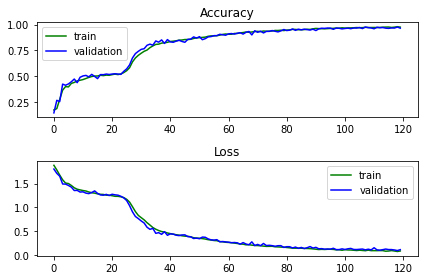

In [94]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [95]:
NUM_DISPLAY = 30

print("{:20}|{:7}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:8} {}".format(question, label, prediction))

질문                  |실제값    |예측값
---------------------------------------
은경이 어디 ?            : 복도       복도
필웅이 어디 ?            : 화장실      화장실
경임이 어디 ?            : 부엌       부엌
경임이 어디 ?            : 복도       복도
경임이 어디 ?            : 부엌       부엌
경임이 어디 ?            : 복도       복도
경임이 어디 ?            : 정원       정원
수종이 어디 ?            : 복도       복도
경임이 어디 ?            : 사무실      사무실
수종이 어디 ?            : 사무실      사무실
필웅이 어디 ?            : 부엌       부엌
필웅이 어디 ?            : 정원       정원
수종이 어디 ?            : 사무실      사무실
필웅이 어디 ?            : 침실       침실
필웅이 어디 ?            : 침실       침실
은경이 어디 ?            : 부엌       부엌
은경이 어디 ?            : 정원       정원
은경이 어디 ?            : 부엌       부엌
수종이 어디 ?            : 사무실      사무실
은경이 어디 ?            : 부엌       부엌
필웅이 어디 ?            : 복도       복도
은경이 어디 ?            : 사무실      사무실
은경이 어디 ?            : 사무실      사무실
경임이 어디 ?            : 복도       복도
수종이 어디 ?            : 침실       침실
경임이 어디 ?            : 침실       침실
필웅이 어디 ?            : 침실       침실
수종

## Step 3. 한국어에서의 모델 정확도 확인해보기
앞서 만든 메모리 네트워크는 영어권 데이터에서는 보편적으로 약 96% 이상의 높은 성능을 보입니다. 하이퍼파라미터를 잘 조정하면 이보다 더 높은 정확도가 나오기도 합니다. 그렇다면 메모리 네트워크가 한국어에서도 영어만큼 잘 동작할까요? 직접 확인해 봅시다.

# 총평

## 루브릭 

1. 한국어의 특성에 알맞게 전처리가 진행되었다.
- 한국어 특성에 따른 토큰화, 임베딩을 거쳐 데이터셋이 적절히 구성되었다.
    - 결과: 노드를 따라 해보니 할 수 있었다.
    
2. 메모리 네트워크가 정상적으로 구현되어 학습이 안정적으로 진행되었다.
- validation loss가 안정적으로 수렴하는 것을 확인하고 이를 시각화하였다.
    - 결과: 불용어 제거 전 모델과, 제거 후 모델 모두 안정적으로 그래프가 나타났다.

3. 메모리 네트워크를 통해 한국어 bAbI 태스크의 높은 정확도를 달성하였다.
- 추론 태스크의 테스트 정확도가 90% 이상 달성하였다.
    - 결과: 불용어 제거 전에는 93.2%였지만 불용어 제거 후 96.5%를 얻을 수 있었다.
    
## 느낀점

이번 노드는 나도 충분히 해낼 수 있는 노드였다. 이렇게 해결하는 것이 맞는지 모르겠지만 불용어 제거 하는 것을 어떻게 하는지 몰라 난감했다. 그러다 postproceccer.pos(sent)를 찍어보니 단어와 그 단어의 품사가 같이 나오는 것을 알았고 리스트에 단어만 받는 것으로 바꿔보니 해결이 되었다. 